In [1]:
# returns banana 2-dim density and sampler
import numpy as np
from scipy.special import gamma
import scipy.stats as stats
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd

In [2]:
from gurobipy import *

ModuleNotFoundError: No module named 'gurobipy'

<function matplotlib.pyplot.show(close=None, block=None)>

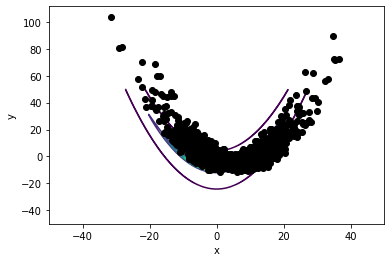

In [8]:
b = 0.1
def p_aux(x, K):
    banana = tfp.experimental.inference_gym.targets.Banana(
        ndims=K, curvature=b, name='banana', pretty_name='Banana'
    )
    return np.array(np.exp(banana.unnormalized_log_prob(x)))
def p(x): return p_aux(x, 2)

def sample(size, K, noise = 10):
    banana = tfp.experimental.inference_gym.targets.Banana(
        ndims=K, curvature=b, name='banana', pretty_name='Banana'
    )
    return np.array(banana.sample(sample_shape=(size)) + noise*np.random.rand(size, K))

len = 1000
xx = np.linspace(-50, 50, len)
yy = np.linspace(-50, 50, len)
tt = np.array(np.meshgrid(xx, yy)).T.reshape(len**2, 2)
zz = p(tt).reshape(len, len).T

ss = sample(1000, 2)

#print(tt, tt2, zz2, zz3)
plt.contour(xx, yy, zz)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(ss[:, 0], ss[:, 1], 'ok')
plt.show